# PyTorch MNIST Basic Example

## Introduction

This tutorial focuses on how to train a CNN model with Fed-BioMed nodes using the PyTorch framework on the MNIST dataset. You will learn; 

- How to prepare your environment to be able to train your model
- How to create a model class to run it in a single node which works as a different process in your local machine.
- How to create a federated learning experiment. 
- How to load and inspect your model parameters. 
- How to test your model using test dataset.

**Note:** In the following steps, we will be running this example using two nodes. 

## Before you start

Before starting this tutorial please make sure that you have a clean environment. Additionally, please terminate running nodes if there is any. Please run the following command in the main Fed-BioMed directory to clean your environment. If you need more help to manage your environment please visit the tutorial for [setting up an enviroment](/tutorials/installation/1-setting-up-environment).
 

```
$ source ${FEDBIOMED_DIR}/scripts/fedbiomed_environment clean
```

**Note**: `${FEDBIOMED_DIR}` is a path relative to based directory of the cloned Fed-BioMed repository. You can set it by running command `export FEDBIOMED_DIR=/path/to/fedbiomed`. This is not required for Fed-BioMed to work but enables you to run the tutorials more easily. 

## 1. Configuring Nodes 

In this tutorial, you will learn how to train your model with a single Fed-BioMed node. Thus, you need to configure a node and add MNIST dataset into it. Node configuration steps require `fedbiomed-node` conda environment. Please make sure that you have the necessary conda environment which is explained in the [installation tutorial](/tutorials/installation/0-basic-software-installation). You can check your environment by running the following command. 

```
$ conda env list
```
If you have all Fed-BioMed environments you are good to go for the node configuration steps. 

Please open a terminal and follow the steps below.    

* **Configuration Steps:**
    * Run `${FEDBIOMED_DIR}/scripts/fedbiomed_run node add` in the terminal
    * It will ask you to select the data type that you want to add. The second option (which is the default) has been configured to add the MNIST dataset. Please type `2` and continue. 
    * Please use default tags which are `#MNIST` and `#dataset`.
    * For the next step, please select the directory that you want to download the MNIST dataset.
    * After the download is completed you will see the details of the MNIST dataset on the screen.
 
Please run the command below in the same terminal to make sure the MNIST dataset is successfully added to the node.  

```
$ ${FEDBIOMED_DIR}/scripts/fedbiomed_run node list
```

Before starting the node, please make sure that you have already launched the network using command `scripts/fedbiomed_run network`. Afterward, all you need to do is to start the node.


```
$ ${FEDBIOMED_DIR}/scripts/fedbiomed_run node start
```



### Start your notebook

You need to start a jupyter notebook and create a new notebook to be able to follow the tutorial. Please open a new terminal window and run the following command to start your notebook.

```
$ ${FEDBIOMED_DIR}/scripts/fedbiomed_run researcher
```


**Note:** If you are having a problem understanding the steps above, we recommend you to follow the [installation tutorial](/tutorials/installation/0-basic-software-installation).



## 2. What is MNIST dataset?

[MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains 60000 grayscale images (of size 28 * 28 pixels) of handwritten digits between 0 and 9. MNIST is commonly used for image classification task: the goal is to classify each image by assigning it to the correct digit. 

For a better visual understanding, we display a few samples from MNIST testing dataset.

In [ ]:
!pip install matplotlib

In [2]:
import os
from fedbiomed.researcher.environ import environ
import tempfile
tmp_dir_model = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+os.sep)


In [3]:
import torch
from torchvision import datasets, transforms


transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

# Get the test dataset
test_set = datasets.MNIST(root = os.path.join(environ['TMP_DIR'], 'mnist_testing.tmp'),
                          download = True, train = False, transform = transform)



Text(0.5, 0.98, 'Few images of MNIST testing dataset')

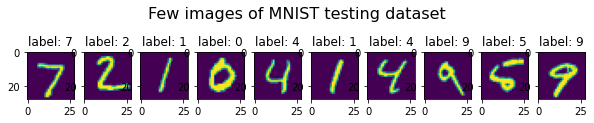

In [4]:
import matplotlib.pyplot as plt

# display a few digits from MNIST testing dataset

nb_digits_to_display = 10

plt.figure(figsize=(10,2)) 
plt.title("Few images of MNIST dataset")
for i in range(nb_digits_to_display):
    plt.subplot(1,nb_digits_to_display, i+1)
    plt.imshow(test_set.data[i].numpy())
    plt.title(f"label: {test_set.targets[i].numpy()}")

plt.suptitle("Few images of MNIST testing dataset", fontsize=16)

## 3. Creating Model 

In this section, you will learn how to create a model class for training.  

### 3.1 Exporting Model Class

Fed-BioMed uploads the scripts that include your model class to a file repository which is accessible by nodes. Afterwards, nodes can download load your model file, build the model and do the training part. Thus, the first thing that you should do is to set a file path to save your model file. By default, in the `fedbiomed.researcher.environ` path it is defined as `tmp` in the base fedbiomed directory. 


In [3]:
model_file = os.path.join(tmp_dir_model.name, 'class_export_mnist.py')

### 3.2 Creating A PyTorch Model

`%%writefile "$model_file"` command saves codes in the following notebook cell on the path that we defined. If you are also using a notebook please do not forget to add this part. 

A PyTorch model in Fed-BioMed is defined as a Python class that inherits from `fedbiomed.common.torchnn.TorchTrainingPlan`. It has the same initialization process as a classic PyTorch model.  In addition, you need to define `tarning_data` for constructing a PyTorch data loader and `training_step` to define the forward and loss function for the training process. 

<div class="note">
    <p>
        You can visit <a href="/getting-started/getting-started">Getting Started</a> page to understand the difference between creating a PyTorch model locally and with Fed-BioMed.
    </p>
</div>

In [ ]:
%%writefile "$model_file"

import torch
import torch.nn as nn
from fedbiomed.common.torchnn import TorchTrainingPlan
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Here we define the model to be used. 
# You can use any class name (here 'Net')
class MyTrainingPlan(TorchTrainingPlan):
    def __init__(self, model_args: dict = {}):
        super(MyTrainingPlan, self).__init__(model_args)
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        # In this case, we need the torch DataLoader classes
        # Since we will train on MNIST, we need datasets and transform from torchvision
        deps = ["from torchvision import datasets, transforms",
               "from torch.utils.data import DataLoader"]
        self.add_dependency(deps)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    def training_data(self, batch_size = 48):
        # Custom torch Dataloader for MNIST data
        transform = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])
        dataset1 = datasets.MNIST(self.dataset_path, train=True, download=False, transform=transform)
        train_kwargs = {'batch_size': batch_size, 'shuffle': True}
        data_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
        return data_loader
    
    def training_step(self, data, target):
        output = self.forward(data)
        loss   = torch.nn.functional.nll_loss(output, target)
        return loss


<div class="note">
    <p>
        Fed-BioMed nodes can be configured to accept only the approved models. Under this configuration, the model files that are sent by a researcher must be approved by the node in advance. For more details, you can visit the tutorial for <a href="/tutorials/advanced/training-with-approved-model-files">working with approved model file</a> and <a href="/user-guide/node/model-manager">user guide for managing nodes.</a>    
    </p>
</div>

 ### 3.3 Define an Experiment
 
 An experiment is a class that orchestrates the training processes that run on different nodes. The experiment has to be initialized with necessary arguments to inform nodes about how to process the training data based on a given model. In this case, first, you need to define `model_arg`, `training_args`, `tags`, and `round`.

 - `model_arg` includes arguments that will pass into `__init__` method of model class. In our case, we don't need to add any arguments.
 - `training_args` includes arguments for training such as learning rate, number of epochs. 
 - `tags` is a list that includes tags that are going to be used for searching related datasets in nodes. In our case, we saved the MNIST dataset with #MNIST and #dataset tags.
 - `rounds` represents the number of training rounds that will be applied in nodes. In each round every nodes complete epochs and send model parameters to the experiment. 


In [7]:
model_args = {}

training_args = {
    'batch_size': 48, 
    'lr': 1e-3, 
    'epochs': 1, 
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

tags =  ['#MNIST', '#dataset']
rounds = 4


Other arguments that should be passed to the experiment are the model file path and the name of the Python class defining the model. The experiment will be responsible of uploading the model to the file repository and informing nodes about how they can access and execute it. 

Finally, you should indicate which method should be choose to aggregate model parameters after every round. The basic federation scheme is federated averaging, implemented in Fed-BioMed in the class  `FedAverage`. 

### 3.4 What happens during the initialization of an experiment?

1. The experiment searches for nodes whose available datasets have been saved with tags indicated in the `tags` argument. Nodes are selected based on a node selection strategy.
2. The experiment prepares the `job` for the nodes according to the provided arguments
3. The model file is uploaded to the provided repository to make it available for the nodes. 

For more details, you can visit [`Experiment` webpage](/user-guide/researcher/experiment). 

Now, let's create our experiment. Since only one node has been created, the experiment will only find a single node for training. 

In [8]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage



exp = Experiment(tags=tags,
                 #nodes=None,
                 model_path=model_file,
                 model_args=model_args,
                 model_class='MyTrainingPlan',
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None)

2021-10-28 10:19:54,901 fedbiomed INFO - Messaging researcher_34c351ee-aa05-4682-be67-5dc8fdc8d4b6 successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x7fefaa9095e0>
2021-10-28 10:19:54,935 fedbiomed INFO - Searching dataset with data tags: ['#MNIST', '#dataset'] for all nodes
2021-10-28 10:19:54,941 fedbiomed INFO - log from: node_42709427-168a-435a-afc5-d538b9542bf2 - DEBUG Message received: {'researcher_id': 'researcher_34c351ee-aa05-4682-be67-5dc8fdc8d4b6', 'tags': ['#MNIST', '#dataset'], 'command': 'search'}
2021-10-28 10:20:04,961 fedbiomed DEBUG - torchnn saved model filename: /tmp/test-fed/fedbiomed/var/tmp8bpn6qn9/my_model_bbff8fba-4283-4031-be16-4ba84fc208ae.py


As an output, you should see the log message from the node which dispose of the MNIST dataset. It means that the search request that contains `#MNIST, #dataset` tags has been successfully received by the node. In the example displayed here, we received messages only from one node, which we created before. 


<div class="note">
    <p>
        One should notice that <code>model_path</code> argument in <code>Experiment</code> is only needed when running <code>Fed-Biomed</code> on jupyter notebooks (not for plain Python scripts).   
    </p>
</div>
****

The experiment also receives loss values during training on each node. In Fed-BioMed, it is possible to use a tensorboard to display loss values during training. Please refer to Fed-BioMed's [tensorboard documentation](/user-guide/researcher/tensorboard) for how to enable the tensorboard.  

Now, let's run the experiment.

In [ ]:
exp.run()

After running the experiment, according to the provided arguments 4 training rounds should be completed on the node that you created. You can check the node id from the output and compare it with the node id which is defined in the config.ini file. After the process is finished, you are ready to inspect the model parameters. 

### 3.5 Extracting Training Results

#### Timing 

Training replies for each round are available via `exp.training_replies()` (index 0 to (`rounds` - 1) ). You can display the keys of each round by running the following script. 

In [10]:
print("\nList the training rounds : ", exp.training_replies().keys())


List the training rounds :  dict_keys([0, 1, 2, 3])


Now, let's see how training details can be accessed from `training_replies()`. The following parameters will be inspected;

- `rtime_training` : Real-time (clock time) spent in the training function on the node 
- `ptime_training`: Process time (user and system CPU) spent in the training function on the node
- `rtime_total`   : Real-time (clock time) spent in the researcher between sending training requests and handling the responses

_Note: The following code accesses the training replies of the last round of the experiment._

In [11]:
print("\nList the nodes for the last training round and their timings : ")
round_data = exp.training_replies()[rounds - 1].data()
for c in range(len(round_data)):
    print("\t- {id} :\
    \n\t\trtime_training={rtraining:.2f} seconds\
    \n\t\tptime_training={ptraining:.2f} seconds\
    \n\t\trtime_total={rtotal:.2f} seconds".format(id = round_data[c]['node_id'],
        rtraining = round_data[c]['timing']['rtime_training'],
        ptraining = round_data[c]['timing']['ptime_training'],
        rtotal = round_data[c]['timing']['rtime_total']))


List the nodes for the last training round and their timings : 
	- node_42709427-168a-435a-afc5-d538b9542bf2 :    
		rtime_training=5.28 seconds    
		ptime_training=20.90 seconds    
		rtime_total=15.02 seconds


#### Federated Parameters
Federated model parameters for each round are available via `exp.aggregated_params()` (index 0 to (`rounds` - 1) ).
For example, you can easily view the federated parameters for the last round of the experiment:

In [12]:
print("\nList the training rounds : ", exp.aggregated_params().keys())

print("\nAccess the federated params for the last training round : ")
print("\t- parameter data: ", exp.aggregated_params()[rounds - 1]['params'].keys())



List the training rounds :  dict_keys([0, 1, 2, 3])

Access the federated params for the last training round : 
	- parameter data:  odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


You can also access the path where the model parameters are saved.

In [ ]:
print("\t- params_path: ", exp.aggregated_params()[rounds - 1]['params_path'])

Finally, to access specific parameters of last round:

In [14]:
print("\t- Parameters of CONV1 layer's biases of last round: \n", exp.aggregated_params()[rounds - 1]['params']['conv1.bias'])

	- Parameters of CONV1 layer's biases of last round: 
 tensor([ 0.1365,  0.2191, -0.0322, -0.1845, -0.0326,  0.1655,  0.2028,  0.0895,
        -0.1745,  0.2297, -0.0334,  0.2638,  0.0338, -0.0030, -0.0631, -0.2885,
        -0.2712,  0.0493, -0.0697, -0.1776, -0.1543, -0.1997, -0.0336, -0.1582,
        -0.2031,  0.0039,  0.3160,  0.2388, -0.2397, -0.0137, -0.1079, -0.0054])


In [ ]:
exp.model_instance()

## 4. PyTorch MNIST Example with Two Nodes

In this section, we will be working on two nodes. Following the previous example, the experiment and training routine will remain unchanged.  Therefore, you just need to configure another node, and add the MNIST dataset with the default tags.

### 4.1 Configuring Second Node

While creating a second node you need to be careful with the node that has already been created. To configure the second node, a different config file has to be defined. Please follow the steps below to configure your second node. 

1. Please open a new terminal and cd into the base directory of fedbiomed.
2. In this step, you need to name a new config file using the `config` parameter. Instead of downloading a new MNIST dataset, you can use the one that you already downloaded in the previous example. To do that please run `${FEDBIOMED_DIR}/scripts/fedbiomed_run node config config-n2.ini --add-mnist /path/to/your/mnist`. It will create a config file named `config-n2.ini`
3. You need to start the new node by indicating the newely created config file. Please run the following command to start the second node `${FEDBIOMED_DIR}/scripts/fedbiomed_run node config config-n2.ini start`

### 4.2 Defining an Experiment 

Since a training model has already been created and saved in the previous example, you don't need to repeat this step here again: the same model will be used for training. However, you can define a new experiment for testing purposes. The experiment will search the MNIST dataset in available nodes. Training arguments are keept the same as in the previous example.

_You can also list datasets and select specific nodes to perform traning. You can visit [listing datasets and selecting nodes](/user-guide/researcher/listing-datasets-and-selecting-nodes) documentation to get more information._

In [5]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

model_args = {}

training_args = {
    'batch_size': 48, 
    'lr': 1e-3, 
    'epochs': 1, 
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

tags =  ['#MNIST', '#dataset']
rounds = 4

expN2 = Experiment(tags=tags,
                 #nodes=None,
                 model_path=model_file,
                 model_args=model_args,
                 model_class='MyTrainingPlan',
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None)

2021-10-28 13:50:44,744 fedbiomed INFO - Messaging researcher_34c351ee-aa05-4682-be67-5dc8fdc8d4b6 successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x7f1f991ca280>
2021-10-28 13:50:44,802 fedbiomed INFO - Searching dataset with data tags: ['#MNIST', '#dataset'] for all nodes
2021-10-28 13:50:44,804 fedbiomed INFO - log from: node_42709427-168a-435a-afc5-d538b9542bf2 - DEBUG Message received: {'researcher_id': 'researcher_34c351ee-aa05-4682-be67-5dc8fdc8d4b6', 'tags': ['#MNIST', '#dataset'], 'command': 'search'}
2021-10-28 13:50:44,805 fedbiomed INFO - log from: node_56cbf88f-2847-4412-b2e4-b3680ff3cbb4 - DEBUG Message received: {'researcher_id': 'researcher_34c351ee-aa05-4682-be67-5dc8fdc8d4b6', 'tags': ['#MNIST', '#dataset'], 'command': 'search'}
2021-10-28 13:50:54,813 fedbiomed INFO - Checking data quality of federated datasets...
2021-10-28 13:50:54,876 fedbiomed DEBUG - torchnn saved model filename: /tmp/test-fed/fedbiomed/var/

You can see from the output that the search request has been sent to 2 nodes by the experiment.

Now, let's run the experiment. 

In [ ]:
expN2.run()

## 5. Testing Federated Model

In this section, we will create a test function to obtain accuracy, loss, and confusion matrix using the test MNIST dataset. 

### 5.1 Aggregated Parameters 

`model_instance` returns the model that we have created in the previous section. It is possible to load specific aggregated parameters which are obtained in every round. Thereafter, it will be ready to make predictions using those parameters. The last round gives the last aggregated model parameters which represents the final model.   

In [ ]:
fed_model = expN2.model_instance()
fed_model.load_state_dict(expN2.aggregated_params()[rounds - 1]['params'])

### 5.2 Creating A Test Function

Let's create a test function that returns loss, accuracy, and confusion matrix. 

In [10]:
import pandas as pd
import torch.nn.functional as F
# Test function 
def testing_accuracy(model, data_loader):
    model.eval()
    test_loss = 0
    device = 'cpu'

    y_pred = []
    y_actu = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            y_pred.extend(torch.flatten(pred).tolist()) 
            y_actu.extend(target.tolist())
           
    y_pred = pd.Series(y_pred, name='Actual')
    y_actu = pd.Series(y_actu, name='Predicted')
    cm = pd.crosstab(y_actu, y_pred)
    correct = sum([cm.iloc[i,i] for i in range(len(cm))])
    
    test_loss /= len(data_loader.dataset)
    accuracy = 100*correct/len(test_loader.dataset)

    return(test_loss, accuracy, cm)

We will use the MNIST test dataset for testing our federated model. You can download this dataset set from `torchvision.dataset`. 

In [11]:
import torch
from torchvision import datasets, transforms


transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

# Get the test dataset
test_set = datasets.MNIST(root = os.path.join(environ['TMP_DIR'], 'mnist_testing.tmp'), download = True, train = False, transform = transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

Now, it is time to get performance results

In [12]:
test_results = testing_accuracy(fed_model, test_loader)

print("- Test Loss: ", test_results[0], "\n")
print("- Accuracy: ", test_results[1], "\n")
print("- Confusion Matrix: \n \n",  test_results[2] )

- Test Loss:  0.06924210393726826 

- Accuracy:  97.83 

- Confusion Matrix: 
 
 Actual       0     1     2    3    4    5    6    7    8    9
Predicted                                                    
0          968     1     2    0    0    1    2    1    2    3
1            0  1127     1    3    0    0    3    0    1    0
2            8     3  1002    2    2    0    0   10    5    0
3            0     0     2  991    0    6    0    8    2    1
4            1     0     1    0  952    0    5    0    2   21
5            1     0     1    6    0  879    2    1    1    1
6            8     3     0    0    2    4  939    0    2    0
7            1     1    13    6    4    1    0  992    1    9
8            4     1     2    2    2    1    1    4  944   13
9            3     5     0    3    2    1    0    4    2  989


### 5.3 Creating Heatmap for Confusion Matrix

We will use `matplotlib` for plotting results. If you have followed all the steps in this tutorial, you must have installed this library in the section 2. Otherwise, you can run `!pip install matplotlib` command in a notebook cell.  

Text(0.5, 1.0, 'Confusion Matrix')

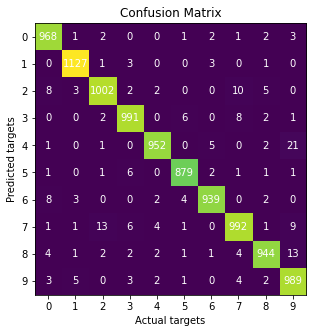

In [13]:
import numpy as np
import matplotlib.pyplot as plt

conf_matrix = test_results[2].to_numpy()

fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(conf_matrix)

ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text = ax.text(j, i, conf_matrix[i, j],
                       ha="center", va="center", color="w")
        
ax.set_xlabel('Actual targets')
ax.set_ylabel('Predicted targets')
ax.set_title('Confusion Matrix')

### 5.4 Plotting Loss for Each round
In this section, we will plot loss values that are obtained over the test dataset using model parameters of every round.

In [14]:
errors = []

for i in range(rounds):
    fed_model = expN2.model_instance()
    fed_model.load_state_dict(expN2.aggregated_params()[i]['params'])
    loss = testing_accuracy(fed_model, test_loader)[0]
    errors.append(loss)

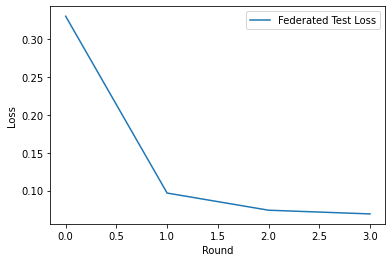

In [15]:
### Plotting 
plt.plot(errors, label = 'Federated Test Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title("Log Likelihood Loss evolution over number of rounds")
plt.legend()

